In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/pytorch-nested-unet

/content/drive/MyDrive/pytorch-nested-unet


#Installing Libraries

In [ ]:
!pip3 install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


#Importing Modules

In [ ]:
import os 
import torch
from torch import nn
from collections import OrderedDict
from os.path import exists
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import yaml
import cv2
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm

import archs
import losses
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter, str2bool

# Defining Variables

In [ ]:
dataset_path='inputs/data-science-bowl-2018'
name = None
epochs = 100
batch_size = 16
arch = 'NestedUNet'
deep_supervision = False
input_channels = 3
num_classes = 1
input_w = 96
input_h = 96
loss = 'BCEDiceLoss'
dataset = 'dsb2018_96'
img_ext = '.png'
mask_ext = '.png'
optimizer = 'SGD'
learning_rate = 1e-3
momentum = 0.9
weight_decay = 1e-4
nesterov = False
scheduler = 'CosineAnnealingLR'
min_lr = '1e-5'
factor = 0.1
patience = 2
milestones = '1,2'
gamma = 2/3
early_stopping = -1
num_workers = 4

#Downloading Dataset

In [ ]:
if os.path.exists(dataset_path) is False:
  print("Downloading Dataset")

  os.makedirs('inputs/data-science-bowl-2018/stage1_test')
  os.makedirs('inputs/data-science-bowl-2018/stage1_train')
  !gdown https://drive.google.com/u/0/uc?id=1Sjaq5gMb1-EVeIDkxu_4MfZfQeAvaQcD&export=download
  !gdown https://drive.google.com/u/0/uc?id=1bTjLI6VEhxgw1vC98wGr2pBlhu9l5y86&export=download
  print('Downloading Model')
  !gdown https://drive.google.com/u/0/uc?id=1kFLV4yu6rJvdK2GgUr_kzuMQogh1N97S&export=download
  !unzip stage1_train.zip -d inputs/data-science-bowl-2018/stage1_train 
  !unzip stage1_test.zip -d inputs/data-science-bowl-2018/stage1_test

else:
  print('Dataset already Downloaded')

Dataset already Downloaded


# Defining Model

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

# Training

In [ ]:
ARCH_NAMES = archs.__all__
LOSS_NAMES = losses.__all__
LOSS_NAMES.append('BCEWithLogitsLoss')
optimizer = 'SGD'
scheduler = 'CosineAnnealingLR'


def train(deep_supervision, train_loader, model, criterion, optimizer):
    model_path = 'models/dsb2018_96_NestedUNet_woDS/model.pth'
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}
    
    file_exists = exists(model_path)
    if file_exists == True:
      model.load_state_dict(torch.load(model_path))
      print("Pretrained Model loaded")

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target, _ in train_loader:
        input = input#.cuda()
        target = target#.cuda()

        # compute output
        if deep_supervision:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_supervision, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            # compute output
            if deep_supervision:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


if name is None:
    if deep_supervision:
        name = '%s_%s_wDS' % (dataset, arch)
    else:
        name = '%s_%s_woDS' % (dataset, arch)
os.makedirs('models/%s' % name, exist_ok=True)

print('-' * 20)
# define loss function (criterion)
if loss == 'BCEWithLogitsLoss':
    criterion = nn.BCEWithLogitsLoss()#.cuda()
else:
    criterion = losses.__dict__[loss]()#.cuda()

cudnn.benchmark = True

# create model
print("=> creating model %s" % arch)
model = archs.__dict__[arch](num_classes,input_channels,deep_supervision)

model = model#.cuda()

params = filter(lambda p: p.requires_grad, model.parameters())
if optimizer == 'Adam':
    optimizer = optim.Adam(
        params, lr=learning_rate, weight_decay=weight_decay)
    
elif optimizer == 'SGD':
    optimizer = optim.SGD(params, lr=learning_rate, momentum=momentum,
                          nesterov=nesterov, weight_decay=weight_decay)
else:
    raise NotImplementedError

if scheduler == 'CosineAnnealingLR':
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=min_lr)
elif scheduler == 'ReduceLROnPlateau':
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience,
                                                verbose=1, min_lr=min_lr)
elif scheduler == 'MultiStepLR':
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(e) for e in milestones.split(',')], gamma=gamma)
elif scheduler == 'ConstantLR':
    scheduler = None
else:
    raise NotImplementedError

# Data loading code
img_ids = glob(os.path.join('inputs', dataset, 'images', '*' + img_ext))
print(img_ids)
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)

train_transform = Compose([
    transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightness(),
        transforms.RandomContrast(),
    ], p=1),
    transforms.Normalize(),
])

val_transform = Compose([
    transforms.Normalize(),])

train_dataset = Dataset(
    img_ids=train_img_ids,
    img_dir=os.path.join('inputs', dataset, 'images'),
    mask_dir=os.path.join('inputs', dataset, 'masks'),
    img_ext=img_ext,
    mask_ext=mask_ext,
    num_classes=num_classes,
    transform=train_transform)
val_dataset = Dataset(
    img_ids=val_img_ids,
    img_dir=os.path.join('inputs', dataset, 'images'),
    mask_dir=os.path.join('inputs', dataset, 'masks'),
    img_ext=img_ext,
    mask_ext=mask_ext,
    num_classes=num_classes,
    transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False)

log = OrderedDict([
    ('epoch', []),
    ('lr', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0
for epoch in range(epochs):
    print('Epoch [%d/%d]' % (epoch, epochs))

    # train for one epoch
    train_log = train(deep_supervision, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(deep_supervision, val_loader, model, criterion)

    if scheduler == 'CosineAnnealingLR':
        scheduler.step()
    elif scheduler == 'ReduceLROnPlateau':
        scheduler.step(val_log['loss'])

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
          % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['lr'].append(learning_rate)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                              name, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                    name)
        best_iou = val_log['iou']
        print("=> saved best model",'models/%s/model.pth')
        trigger = 0

    # early stopping
    if early_stopping >= 0 and trigger >= early_stopping:
        print("=> early stopping")
        break

--------------------
=> creating model NestedUNet
['inputs/dsb2018_96/images/a7f767ca9770b160f234780e172aeb35a50830ba10dc49c526f4712451abe1d2.png', 'inputs/dsb2018_96/images/f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5.png', 'inputs/dsb2018_96/images/b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f.png', 'inputs/dsb2018_96/images/62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461.png', 'inputs/dsb2018_96/images/be26966900aa0e5b41d5a8ecafe04281b37deb05c5cd027968d7b74143398174.png', 'inputs/dsb2018_96/images/08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada.png', 'inputs/dsb2018_96/images/bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96.png', 'inputs/dsb2018_96/images/f4faa3a409014db1865074c5f66a0255f71ae3faba03265da0b3b91f68e8a8f0.png', 'inputs/dsb2018_96/images/f0c9f135c62572f3669a75b2c735e4477dc77fac85e653426ee2b3bcfbed7aaf.png', 'inputs/dsb2018_96/images/6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc2

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Pretrained Model loaded


100%|██████████| 9/9 [00:31<00:00,  3.51s/it, loss=0.315, iou=0.779]


loss 0.4359 - iou 0.6901 - val_loss 0.3149 - val_iou 0.7794
=> saved best model models/%s/model.pth
Epoch [1/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:27<00:00,  3.09s/it, loss=0.322, iou=0.772]


loss 0.4171 - iou 0.6923 - val_loss 0.3220 - val_iou 0.7722
Epoch [2/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:27<00:00,  3.09s/it, loss=0.364, iou=0.749]


loss 0.4208 - iou 0.6846 - val_loss 0.3636 - val_iou 0.7485
Epoch [3/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:30<00:00,  3.37s/it, loss=0.365, iou=0.763]


loss 0.4148 - iou 0.6885 - val_loss 0.3648 - val_iou 0.7630
Epoch [4/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:28<00:00,  3.17s/it, loss=0.405, iou=0.753]


loss 0.4104 - iou 0.6956 - val_loss 0.4048 - val_iou 0.7532
Epoch [5/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:27<00:00,  3.08s/it, loss=0.815, iou=0.308]


loss 0.4278 - iou 0.6662 - val_loss 0.8151 - val_iou 0.3076
Epoch [6/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:28<00:00,  3.14s/it, loss=0.309, iou=0.792]


loss 0.4217 - iou 0.6820 - val_loss 0.3092 - val_iou 0.7923
=> saved best model models/%s/model.pth
Epoch [7/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:27<00:00,  3.06s/it, loss=0.285, iou=0.779]


loss 0.3936 - iou 0.6937 - val_loss 0.2848 - val_iou 0.7792
Epoch [8/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:27<00:00,  3.06s/it, loss=0.27, iou=0.792]


loss 0.3824 - iou 0.7037 - val_loss 0.2705 - val_iou 0.7921
Epoch [9/100]
Pretrained Model loaded


 33%|███▎      | 11/33 [01:52<03:41, 10.06s/it, loss=0.384, iou=0.723]

#Inference 

=> creating model NestedUNet


9it [00:25,  2.78s/it]


IoU: 0.7923


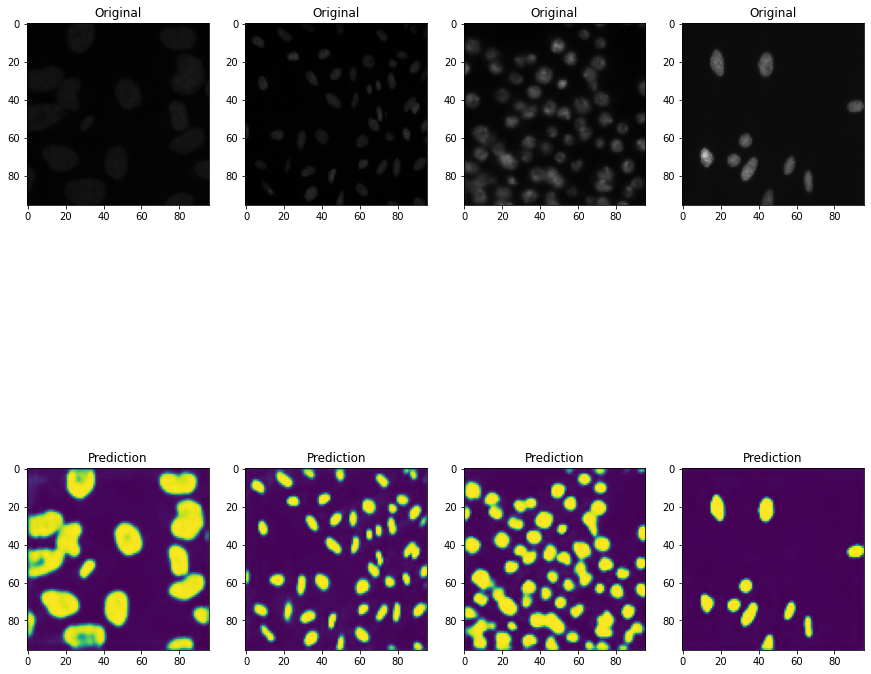

In [ ]:
# create model
print("=> creating model %s" % arch)
model = archs.__dict__[arch](num_classes,input_channels,deep_supervision)

model = model

# Data loading code
img_ids = glob(os.path.join('inputs', dataset, 'images', '*' + img_ext))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

_, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)

model.load_state_dict(torch.load('models/dsb2018_96_NestedUNet_woDS/model.pth'))
model.eval()

val_transform = Compose([
    transforms.Normalize(),
])

val_dataset = Dataset(
    img_ids=val_img_ids,
    img_dir=os.path.join('inputs', dataset, 'images'),
    mask_dir=os.path.join('inputs', dataset, 'masks'),
    img_ext=img_ext,
    mask_ext=mask_ext,
    num_classes=num_classes,
    transform=val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False)

avg_meter = AverageMeter()

for c in range(num_classes):
    os.makedirs(os.path.join('outputs', 'dsb2018_96_NestedUNet_woDS', str(c)), exist_ok=True)
with torch.no_grad():
    display_imgs = []
    names = []
    plt.figure(figsize=(15,15))
    for input, target, meta in tqdm(val_loader, total=4):#len(val_loader)):
        # compute output
        if deep_supervision:
            output = model(input)[-1]
        else:
            output = model(input)

        iou = iou_score(output, target)
        avg_meter.update(iou, input.size(0))

        output = torch.sigmoid(output).cpu().numpy()



        for i in range(len(output)):
            for c in range(num_classes):
                pred_img = (output[i, c] * 255).astype('uint8')
                display_imgs.append(pred_img)
                names.append('inputs/dsb2018_96/images/'+meta['img_id'][i] + '.png')
                cv2.imwrite(os.path.join('outputs', 'dsb2018_96_NestedUNet_woDS', str(c), meta['img_id'][i] + '.jpg'),pred_img)
              
    l = 1
    m = 5
    for img in range(0,4):
      original_img = Image.open(names[img])
      plt.subplot(2,4,l)
      plt.imshow(original_img)
      plt.title('Original')

      plt.subplot(2,4,m)
      plt.imshow(display_imgs[img])
      plt.title('Prediction')
      l=l+1
      m=m+1


print('IoU: %.4f' % avg_meter.avg)